In [25]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import hdbscan
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import json

with open('tagged_data2.json') as file:
    bookmarks = json.load(file)

# Preprocess the bookmarks data
bookmarks_data = [{"title": bookmark["title"], "url": bookmark["url"], "tags": " ".join(bookmark["tags"])} for bookmark in bookmarks]

# Extract features using TF-IDF vectorization
vectorizer = TfidfVectorizer()
features = vectorizer.fit_transform([bookmark["tags"] for bookmark in bookmarks_data])

# Reduce dimensionality using PCA
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(features.toarray())

# Apply HDBSCAN clustering
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, gen_min_span_tree=True)
clusterer.fit(reduced_features)

# Build the cluster hierarchy
cluster_hierarchy = {}
for _, row in clusterer.condensed_tree_.to_pandas().iterrows():
    child = row['child']
    parent = row['parent']
    if parent not in cluster_hierarchy:
        cluster_hierarchy[parent] = {'children': []}
    if child not in cluster_hierarchy:
        cluster_hierarchy[child] = {'children': []}
    cluster_hierarchy[parent]['children'].append(child)

# Find the root cluster
root_cluster = None
for cluster_id in cluster_hierarchy:
    if cluster_id not in [child for parent in cluster_hierarchy for child in cluster_hierarchy[parent]['children']]:
        root_cluster = cluster_id
        break

# Map cluster IDs to their corresponding bookmarks
cluster_bookmarks = {}
for i, cluster_id in enumerate(clusterer.labels_):
    if cluster_id not in cluster_bookmarks:
        cluster_bookmarks[cluster_id] = []
    cluster_bookmarks[cluster_id].append(bookmarks_data[i])

# Generate prompts for each cluster considering the hierarchy
def generate_prompts(cluster_id, indent=""):
    prompts = []
    folder_name = f"Folder {cluster_id}"
    if cluster_id in cluster_bookmarks:
        bookmarks = cluster_bookmarks[cluster_id]
        bookmark_titles = [bookmark["title"] for bookmark in bookmarks]
        bookmark_titles_str = "\n".join([f"{indent}  - {title}" for title in bookmark_titles])
        prompt = f"{indent}Folder: {folder_name}\n{bookmark_titles_str}"
        prompts.append(prompt)
    
    if cluster_id in cluster_hierarchy:
        children = cluster_hierarchy[cluster_id]["children"]
        for child_id in children:
            child_prompts = generate_prompts(child_id, indent + "  ")
            prompts.extend(child_prompts)
    
    return prompts

prompts = generate_prompts(root_cluster)

# Print the generated prompts
for prompt in prompts:
    print(prompt)
    print()

                Folder: Folder 0.0
                  - Agent-OM: Leveraging LLM Agents for Ontology Matching - 2312.00326v2.pdf
                  - [2109.02124] The Koha Code: A Biological Theory of Memory
                  - AlphaCode
                  - Page not found | CSE Research Experience for Undergraduates | Washington University in St. Louis
                  - REU: Big Data Analytics at Oklahoma State University
                  - http://reu.cs.wright.edu/projects.html
                  - DIMACS REU: Research Experience for Undergraduates
                  - SRCA-REU - Research Projects

                Folder: Folder 4.0
                  - Latent Space | swyx & Alessio | Substack
                  - DBOS | A Database-Oriented Operating System
                  - Svelte Recipes: World Map
                  - 404 Not Found
                  - GitHub Accelerator
                  - CodePen: Online Code Editor and Front End Web Developer Community
                  - Transitio

<Axes: ylabel='distance'>

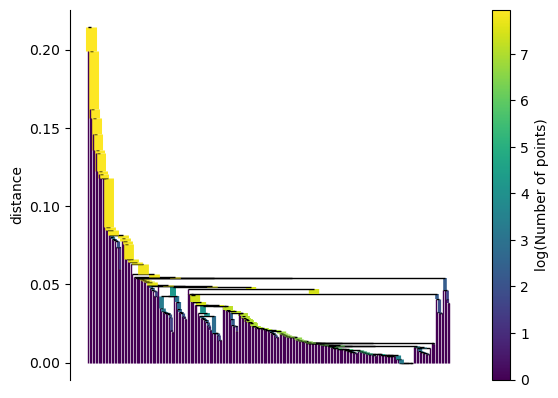

In [26]:
clusterer.single_linkage_tree_.plot(cmap='viridis', colorbar=True)

<Axes: ylabel='$\\lambda$ value'>

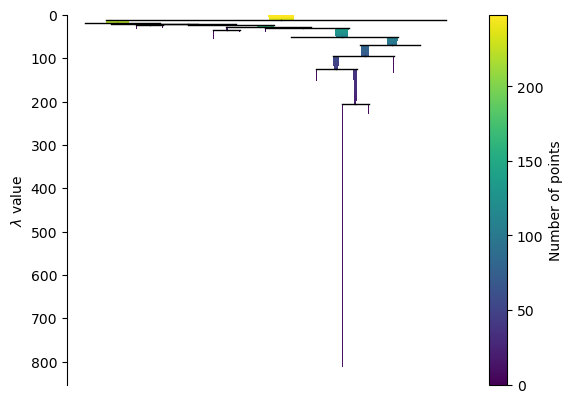

In [19]:
clusterer.condensed_tree_.plot()

/home/tim/miniconda3/lib/python3.12/site-packages/hdbscan/plots.py:383: UserWarning: Infinite lambda values encountered in chosen clusters. This might be due to duplicates in the data.
  warn('Infinite lambda values encountered in chosen clusters.'


<Axes: ylabel='$\\lambda$ value'>

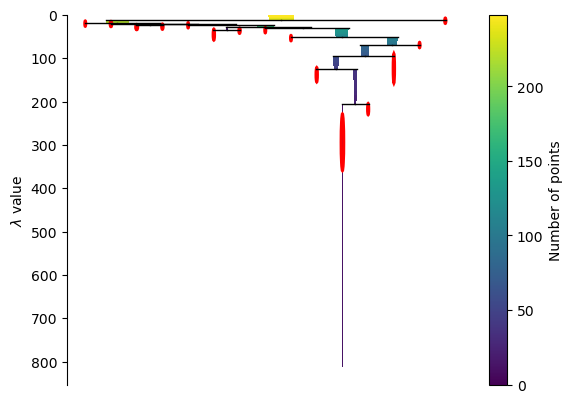

In [20]:
clusterer.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())

In [21]:
# ... (previous code remains the same)

# Generate prompts for each cluster considering the hierarchy
def generate_prompts(cluster_id, indent=""):
    prompts = []
    folder_name = f"Folder {cluster_id}"
    if cluster_id in cluster_bookmarks:
        bookmarks = cluster_bookmarks[cluster_id]
        bookmark_titles = [bookmark["title"] for bookmark in bookmarks]
        bookmark_titles_str = "\n".join(bookmark_titles)
        prompt = f"{indent}Folder: {folder_name}\n{indent}{bookmark_titles_str}\n{indent}Folder Name: "
    else:
        prompt = f"{indent}Folder: {folder_name}\n{indent}Folder Name: "
    
    prompts.append(prompt)

    children = cluster_hierarchy[cluster_id]["children"]
    for child_id in children:
        child_prompts = generate_prompts(child_id, indent + "  ")
        prompts.extend(child_prompts)

    return prompts

prompts = generate_prompts(root_cluster)

# Use an LLM to generate folder names (replace this with your actual LLM code)
folder_names = ["Unnamed Folder" for _ in range(len(prompts))]  # Placeholder for LLM-generated names

# Print the generated prompts and folder names
for prompt, folder_name in zip(prompts, folder_names):
    print(prompt + folder_name)
    print()

# ... (remaining code for visualization remains the same)

Folder: Folder 0
Agent-OM: Leveraging LLM Agents for Ontology Matching - 2312.00326v2.pdf
[2109.02124] The Koha Code: A Biological Theory of Memory
AlphaCode
Page not found | CSE Research Experience for Undergraduates | Washington University in St. Louis
REU: Big Data Analytics at Oklahoma State University
DIMACS REU: Research Experience for Undergraduates
SRCA-REU - Research Projects
Folder Name: Unnamed Folder

